# Transfer Learning с MobileNetV2

Предварительно обученная модель - это сеть, которая уже была обучена на большом наборе данных и сохранена, что позволяет нам использовать ее для эффективного дообучения нашей собственной модели. Тот, который мы будем использовать, MobileNetV2, был разработан для обеспечения быстрой и вычислительно эффективной производительности. Он был предварительно обучен в ImageNet, наборе данных, содержащем более 14 миллионов изображений и 1000 классов.

## Наши шаги

- 1.  Установка необходимых пакетов
    - 1.1 Создание датасета и деление его на обучающие и валидационные наборы
- 2. Аугментация
- 3.  Использование MobileNetV2 для Transfer Learning
    - 3.1  Архитектура и особенность MobileNetV2
    - 3.2  "Заморозка весов" слоёв для подготовки к обучении
    - 3.3  Обучение модели 
    - 3.4  Fine-tuning (частичная заморозка весов) для улучшения результата

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/CourseWork/ProjectMask/dataset"


/content/drive/My Drive/CourseWork/ProjectMask/dataset



## 1 Установка необходимых пакетов

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


### 1.1 Создание датасета и деление его на обучающие и валидационные наборы
При обучении и оценке моделей глубокого обучения в Keras создание набора данных из изображений, хранящихся на памяти, является простым и быстрым. Вызовем метод "image_data_set_from_directory()" для чтения из каталога и создания как обучающих, так и валидационных наборов данных.

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
directory = "/content/drive/My Drive/CourseWork/ProjectMask/dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode='rgb',
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode='rgb',
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 2835 files belonging to 3 classes.
Using 2268 files for training.
Found 2835 files belonging to 3 classes.
Using 567 files for validation.


Теперь давайте взглянем на некоторые изображения из обучающего набора



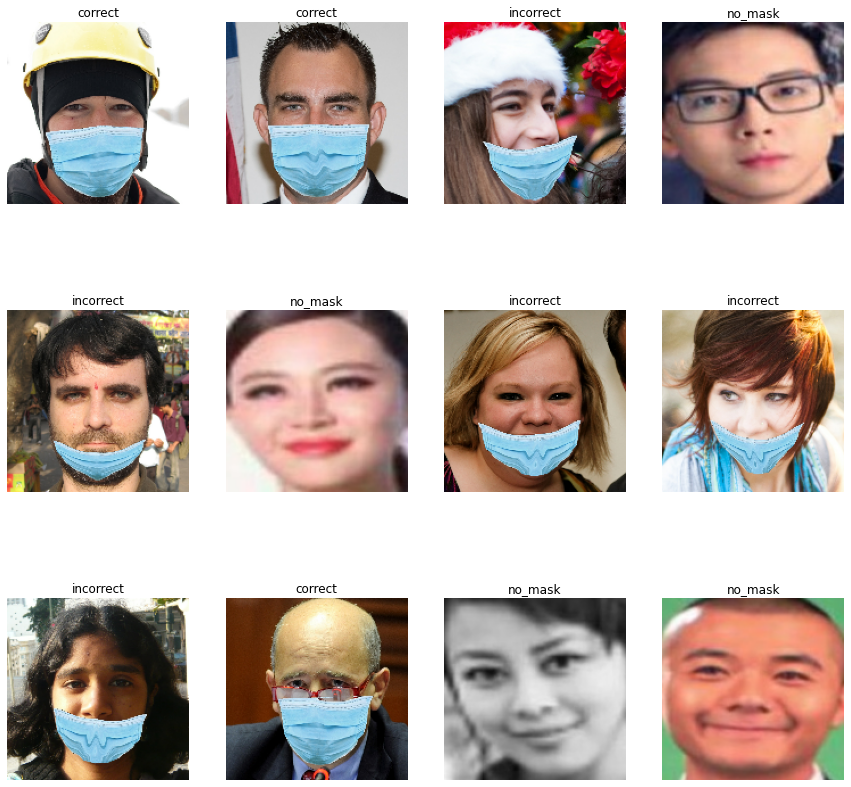

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

### data_augmenter

Фунция для аугментации изображений.

In [ ]:
def data_augmenter():
    '''
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
    
    return data_augmentation

Взглянем на то, как изображение из обучающего набора было дополнено простыми преобразованиями:

От одного фото до 9 вариаций этого фото всего лишь за три строки кода. Теперь нашей модели есть чему поучиться.

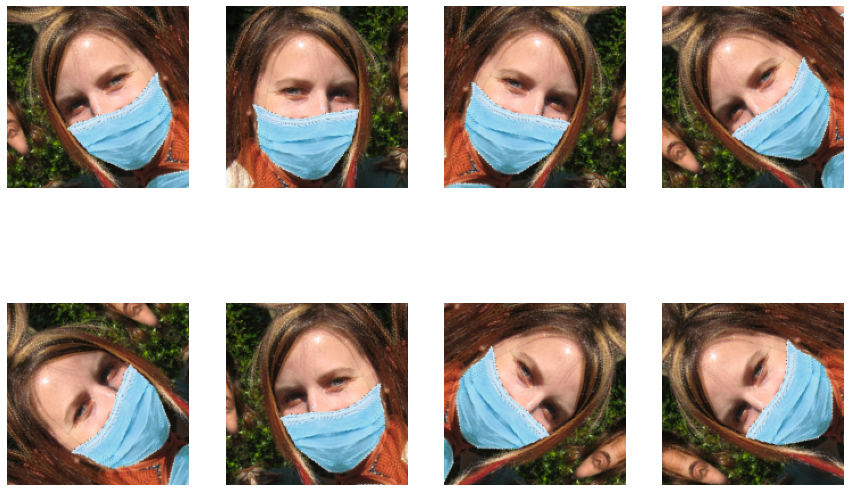

In [ ]:
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(15, 8))
    first_image = image[0]
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Затем мы применим свой первый инструмент из приложения MobileNet в TensorFlow, чтобы нормализовать ввод. Поскольку мы используем предварительно обученную модель, которая была обучена значениям нормализации [-1,1], рекомендуется повторно использовать этот стандарт с tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## 3 Использование MobileNetV2 для Transfer Learning

MobileNetV2 была обучена в наборе данных ImageNet и оптимизирована для работы в мобильных и других устройствах с низким энергопотреблением. Он имеет глубину 155 слоев (на случай, если вам захочется построить модель самостоятельно, приготовьтесь к долгому путешествию!) и очень эффективен для задач обнаружения объектов и сегментации изображений, а также для задач классификации, подобных этой. Архитектура имеет три определяющие характеристики:


Загружаем предобученную модель MobileNetV2 вместе с весами ImageNet  `weights='imagenet'`.

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14548992/14536120 [==============================] - 0s 0us/step


Выведем сведение модели ниже, чтобы увидеть все слои модели, размеры выходных данных и общее количество параметров, обучаемых и не обучаемых.

In [ ]:
base_model.summary()

Обратим внимание на последние 2 слоя здесь. Это так называемые верхние слои, и они отвечают за классификацию в модели

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

global_average_pooling2d
predictions



### 3.2 - Заморозка весов базовой модели для подготовки к обучении

В следующих разделах рассмотрим, как можно использовать предварительно обученную модель для наших целе, чтобы она могла распознавать маски. Мы сделаем это в три этапа:

1. Удаляем последний слой (слой классификации)
    * Установить `include_top` в `base_model` как False
2. Добавляем новый слой классификации
    * Для трех классов добавим три новых нейрона вместо 1000
3. Заморозим базовую модель и обучим вновь созданный слой классификации.
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Установим `base model.trainable=False", чтобы избежать изменение

In [ ]:
def Mask_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):    
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights='imagenet')
    base_model.trainable = False 

    #создадим входной слой (такой же, как входной размер MobileNetV2)
    inputs = tf.keras.Input(shape=input_shape) 
    
    #применим Аугментацию данных к входным данным
    data_augmentation = data_augmenter()
    x = data_augmentation(inputs)
    
    # предварительная обработка данных с использованием тех же весов, на которых была обучена модель
    x = preprocess_input(x) 
    
    # установим training=False, чтобы избежать отслеживания статистики в слоях Батч нормализации
    x = base_model(x, training=False) 
    
    # добавим новый слой классификации
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x =tf.keras.layers.Dropout(0.2)(x)
        
    # добавим три новых нейрона, каждый будет отвечать за вероятность своего класса, используем функцию активации Сигмоида
    outputs = tf.keras.layers.Dense(3, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model


### 3.2 - Обучение модели


Создаём свою новую модель, используя функцию data_augmentation, определенную ранее.

In [ ]:
model2 = Mask_model(IMG_SIZE, data_augmentation)

Установим скорость обучения как 0.001, используем оптимизатор Adam, функцию потерь SparseCategoricalCrossentropy(), и метрику sparse_categorical_accuracy()

In [ ]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Будем обучать 10 эпох, и историю обучения храним в переменной history для дальнейшего анализа. Передаем все эти данные в метод .fit(). Дальше модель начнет процесс обучения

In [ ]:
initial_epochs = 10
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/10
36/36 [==============================] - 21s 420ms/step - loss: 0.5458 - sparse_categorical_accuracy: 0.7504 - val_loss: 0.3555 - val_sparse_categorical_accuracy: 0.8624
Epoch 2/10
36/36 [==============================] - 17s 393ms/step - loss: 0.2949 - sparse_categorical_accuracy: 0.8862 - val_loss: 0.2447 - val_sparse_categorical_accuracy: 0.9171
Epoch 3/10
36/36 [==============================] - 17s 396ms/step - loss: 0.2315 - sparse_categorical_accuracy: 0.9118 - val_loss: 0.2083 - val_sparse_categorical_accuracy: 0.9383
Epoch 4/10
36/36 [==============================] - 17s 390ms/step - loss: 0.2006 - sparse_categorical_accuracy: 0.9246 - val_loss: 0.1850 - val_sparse_categorical_accuracy: 0.9365
Epoch 5/10
36/36 [==============================] - 17s 397ms/step - loss: 0.1914 - sparse_categorical_accuracy: 0.9233 - val_loss: 0.1668 - val_sparse_categorical_accuracy: 0.9506
Epoch 6/10
36/36 [==============================] - 17s 395ms/step - loss: 0.1907 - sparse_cate

Так как мы использовали мощные GPU от Google Colab и количество данных не было так велико, обучение не заняло много времени, в среднем 17 секунд на каждую эпоху. Далее посмотрим как шло обучение, посмотрим на графики метрики и функции потерь

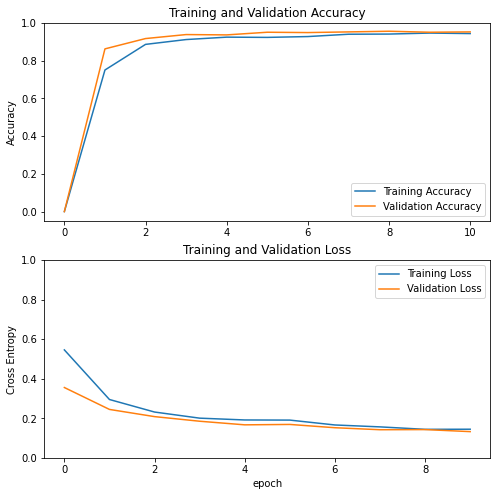

In [ ]:
acc = [0.] + history.history['sparse_categorical_accuracy']
val_acc = [0.] + history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Как мы видим наша модель очень быстро набрала хорошую точность, уже после первой же эпохи, близкое к единице.В последней эпохе на обучаеющем наборе точность равна: 0.9436, а на валидационном наборе 0.9524. Значение функции потерь довольно маленькое 0.1446 - на обучающем наборе данных и 0.1324 - на валидационном. Это все благодаря тому что мы использовали transfer learning, и наша базовая модель, MobileNetV2, была очень хорошо обучена на миллионах данных и хорошо умеет извлекать детали из фотографий.  Возможно наша модель немножко переобучился но это незначительно, посмотрим как будет показывать себя в деле 

In [ ]:
def decode_pred(pred):
    mx=-1
    mx_ind=0
    for i in range(pred.shape[0]):
      if pred[i] > mx:
        mx=pred[i]
        mx_ind=i
    return mx_ind

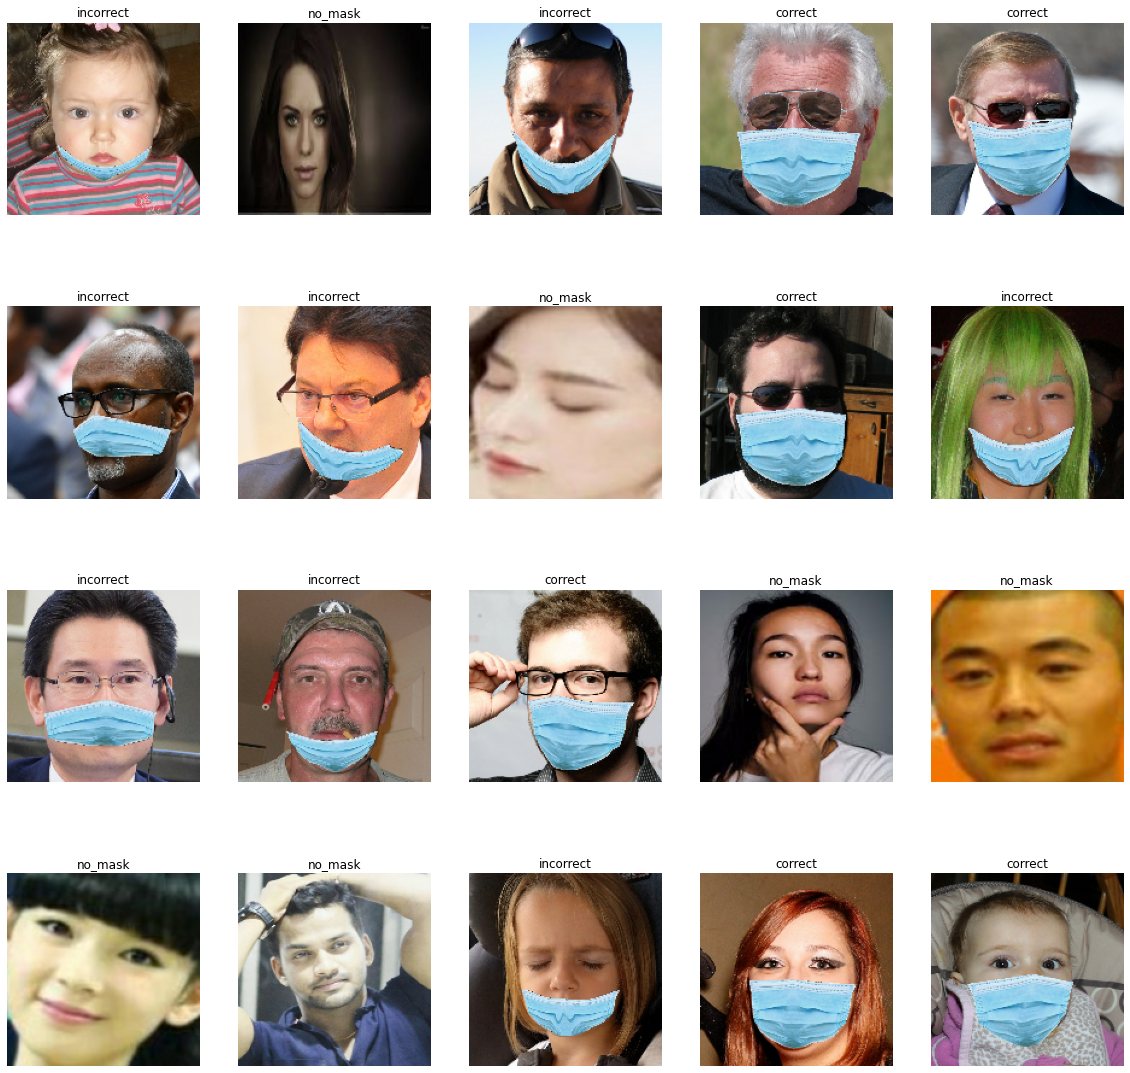

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in validation_dataset.take(1):
    pred=model2(images)
    pred=pred.numpy()
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title=class_names[decode_pred(pred[i])]
        plt.title(title)
        plt.axis("off")

  Как мы видим модель очень хорошо работает, и классифицировала без ошибок на этом примере. Далее сохраним нашу модель, чтобы потом использовать и протестировать её для работы в режиме реального времени 

In [ ]:
model2.save("/content/drive/My Drive/CourseWork/ProjectMask/mask_detection.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Результат довольно хороший, но может быть и лучше, давайте рассмотрим Fine Tuning

### 3.4 - Fine-tuning
Мы можем попробовать Fine-Tuning модели, повторно запустив оптимизатор на последних слоях, чтобы повысить точность. Когда мы используем меньшую скорость обучения, мы делаем меньшие шаги, чтобы модель лучше адаптировался к новым данным. 
Интуиция того, что происходит: ранние слои распознают лишь незначительные детали такие как горизонтальные, вертикальные линии и тд. чемь глубже слой, тем лучше он распознает более значительные и отличительные и уникальные черты. Идея Fine-Tuning'а состоит в том чтобы разморозить последние несколько слоев базовой модели и дообучить с меньшей скоростью обучения, чтобы и они немножко адаптировались к нашим новым данным и лучше распознавали нужные нам черты.

Сначала разморозим базовую модель, установив "base_model.trainable=True", 
потом итерируясь по слоям, в нашем случае, до 120 - го слоя, установим layer.trainable = False, Затем запустим модель снова еще на несколько эпох и посмотрим, улучшилась ли наша точность!

In [ ]:
base_model = model2.layers[4]
base_model.trainable = True

fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
loss_function=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer =tf.keras.optimizers.Adam(base_learning_rate*0.1)
metrics=[tf.keras.metrics.sparse_categorical_accuracy]

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Обучим еще 5 эпох, и посмотрим на результат

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
36/36 [==============================] - 23s 424ms/step - loss: 0.2372 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.0867 - val_sparse_categorical_accuracy: 0.9630
Epoch 11/15
36/36 [==============================] - 17s 400ms/step - loss: 0.0665 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.0672 - val_sparse_categorical_accuracy: 0.9771
Epoch 12/15
36/36 [==============================] - 17s 402ms/step - loss: 0.0599 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.0298 - val_sparse_categorical_accuracy: 0.9859
Epoch 13/15
36/36 [==============================] - 17s 398ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.0367 - val_sparse_categorical_accuracy: 0.9841
Epoch 14/15
36/36 [==============================] - 17s 405ms/step - loss: 0.0251 - sparse_categorical_accuracy: 0.9925 - val_loss: 0.1949 - val_sparse_categorical_accuracy: 0.9418
Epoch 15/15
36/36 [==============================] - 17s 409ms/step - loss: 0.0688 - spars

Видно что результаты улучшились, и достигли почти 0.98 точности, вместо 0.94 что было раньше

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

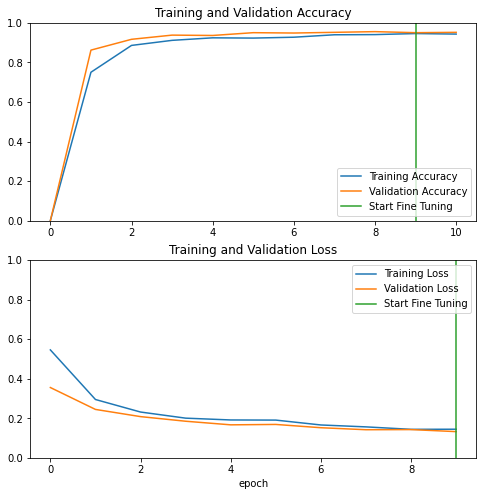

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()